In [1]:
from utils.model_evaluation import plot_test_pred
import pandas as pd
import scipy as sci

#loading the raw test data
X_test = pd.read_csv('./model_data/X_test.csv', index_col=0)
y_test = pd.read_csv('./model_data/y_test.csv', index_col=0)
X_test.drop(columns=['mfc10_residual'], inplace=True)
data = pd.concat((X_test,y_test), axis=1)

In [2]:
# filtering out the values at the two ends of the wing
def std_normalization(data):
    data = (data[(data.x1 > 2603) & (data.x1 <= 13976)])
    y = data[['x1', 'y1']] 
    x = data.drop(['x1', 'y1'], axis=1)
    # finding sum of the mass flow rates of the row
    sum_flows = x.sum(axis=1)
    # normalizing each column with its row sum
    norm_x = x.divide(sum_flows, axis=0)
    norm_x.columns = ['mfc6', 'mfc7', 'mfc8', 'mfc9', 'mfc10', 'mfc1', 'mfc2', 'mfc3', 'mfc4', 'mfc5']
    # norm_x.sum(axis=1)
    return y, norm_x

# y, norm_x = std_normalization(data)

In [3]:
def softmax_normalization(data):
    data = (data[(data.x1 > 2603) & (data.x1 <= 13976)])
    y = data[['x1', 'y1']] 
    x = data.drop(['x1', 'y1'], axis=1)
    # x = tf.convert_to_tensor(x)
    # norm_x = tf.keras.activations.softmax(x, axis=1).numpy()
    norm_x = sci.special.softmax(x, axis=1)
    norm_x = pd.DataFrame(norm_x, 
                          columns=['mfc6', 'mfc7', 'mfc8', 'mfc9', 'mfc10', 'mfc1', 'mfc2', 'mfc3', 'mfc4', 'mfc5'],
                          index=data.index)
    return y, norm_x

y, norm_x = softmax_normalization(data)

In [11]:
full_data = (data[(data.x1 > 2603) & (data.x1 <= 13976)]).drop(['x1', 'y1'], axis=1)
full_data['sum'] =  full_data.sum(axis=1)
full_data.head()

,MFC6,MFC7,MFC8,MFC9,MFC10,MFC1,MFC2,MFC3,MFC4,MFC5,sum
757,0.0435,0.0350,0.0194,0.0000,0.0202,0.1531,0.0510,0.0182,0.0099,0.0000,0.3503
655,0.0150,0.0287,0.0413,0.0382,0.0330,0.0145,0.0298,0.0928,0.0596,0.0233,0.3762
167,0.0090,0.0174,0.0303,0.0957,0.0851,0.0000,0.0134,0.0228,0.0522,0.0548,0.3807
293,0.0000,0.0127,0.0176,0.0344,0.0590,0.0000,0.0106,0.0196,0.1017,0.0851,0.3407
239,0.0228,0.0380,0.0331,0.0206,0.0304,0.0301,0.0876,0.0816,0.0244,0.0119,0.3805


In [12]:
norm_x.head()
norm_x['sum'] =  norm_x.sum(axis=1)
norm_x.head()

,mfc6,mfc7,mfc8,mfc9,mfc10,mfc1,mfc2,mfc3,mfc4,mfc5,sum
757,0.100757,0.099904,0.098358,0.096468,0.098436,0.112428,0.101515,0.098240,0.097428,0.096468,1.0
655,0.097739,0.099087,0.100344,0.100033,0.099514,0.097690,0.099196,0.105647,0.102197,0.098554,1.0
167,0.097088,0.097907,0.099178,0.105881,0.104765,0.096218,0.097516,0.098437,0.101374,0.101638,1.0
293,0.096594,0.097828,0.098309,0.099974,0.102464,0.096594,0.097623,0.098506,0.106934,0.105174,1.0
239,0.098457,0.099965,0.099477,0.098241,0.099208,0.099179,0.105048,0.104420,0.098615,0.097390,1.0


In [4]:
def leakage_prediction(normalized_flows):
    # coordinates of the sensor
    sensors = pd.DataFrame([[2426, 70], [5480, 70], [8661, 191], [11676, 584], [13976, 917], [2603, 5163], 
                            [5723, 5163], [8417, 5103], [11646, 4740], [14641, 4391]], 
                            columns=['x', 'y'], 
                            index=['mfc1', 'mfc2', 'mfc3', 'mfc4', 'mfc5', 'mfc6', 'mfc7', 'mfc8', 'mfc9', 'mfc10']
                            )
    # x coordinate of the sensor
    sensors_x = sensors['x']
    # y coordinate of the sensor
    sensors_y = sensors['y']
    leakage_x = 0
    leakage_y = 0
    for i in range(1,11):
        sensor = 'mfc'+str(i)
        # multiplying each sensor coordinate with its normalized value and adding this value of each sensor together using for loop
        leakage_x = leakage_x + sensors_x[sensor] * normalized_flows[sensor] 
        leakage_y = leakage_y + sensors_y[sensor] * normalized_flows[sensor]
    leakage = pd.concat((leakage_x, leakage_y),axis=1)
    return leakage
leakage = leakage_prediction(norm_x)

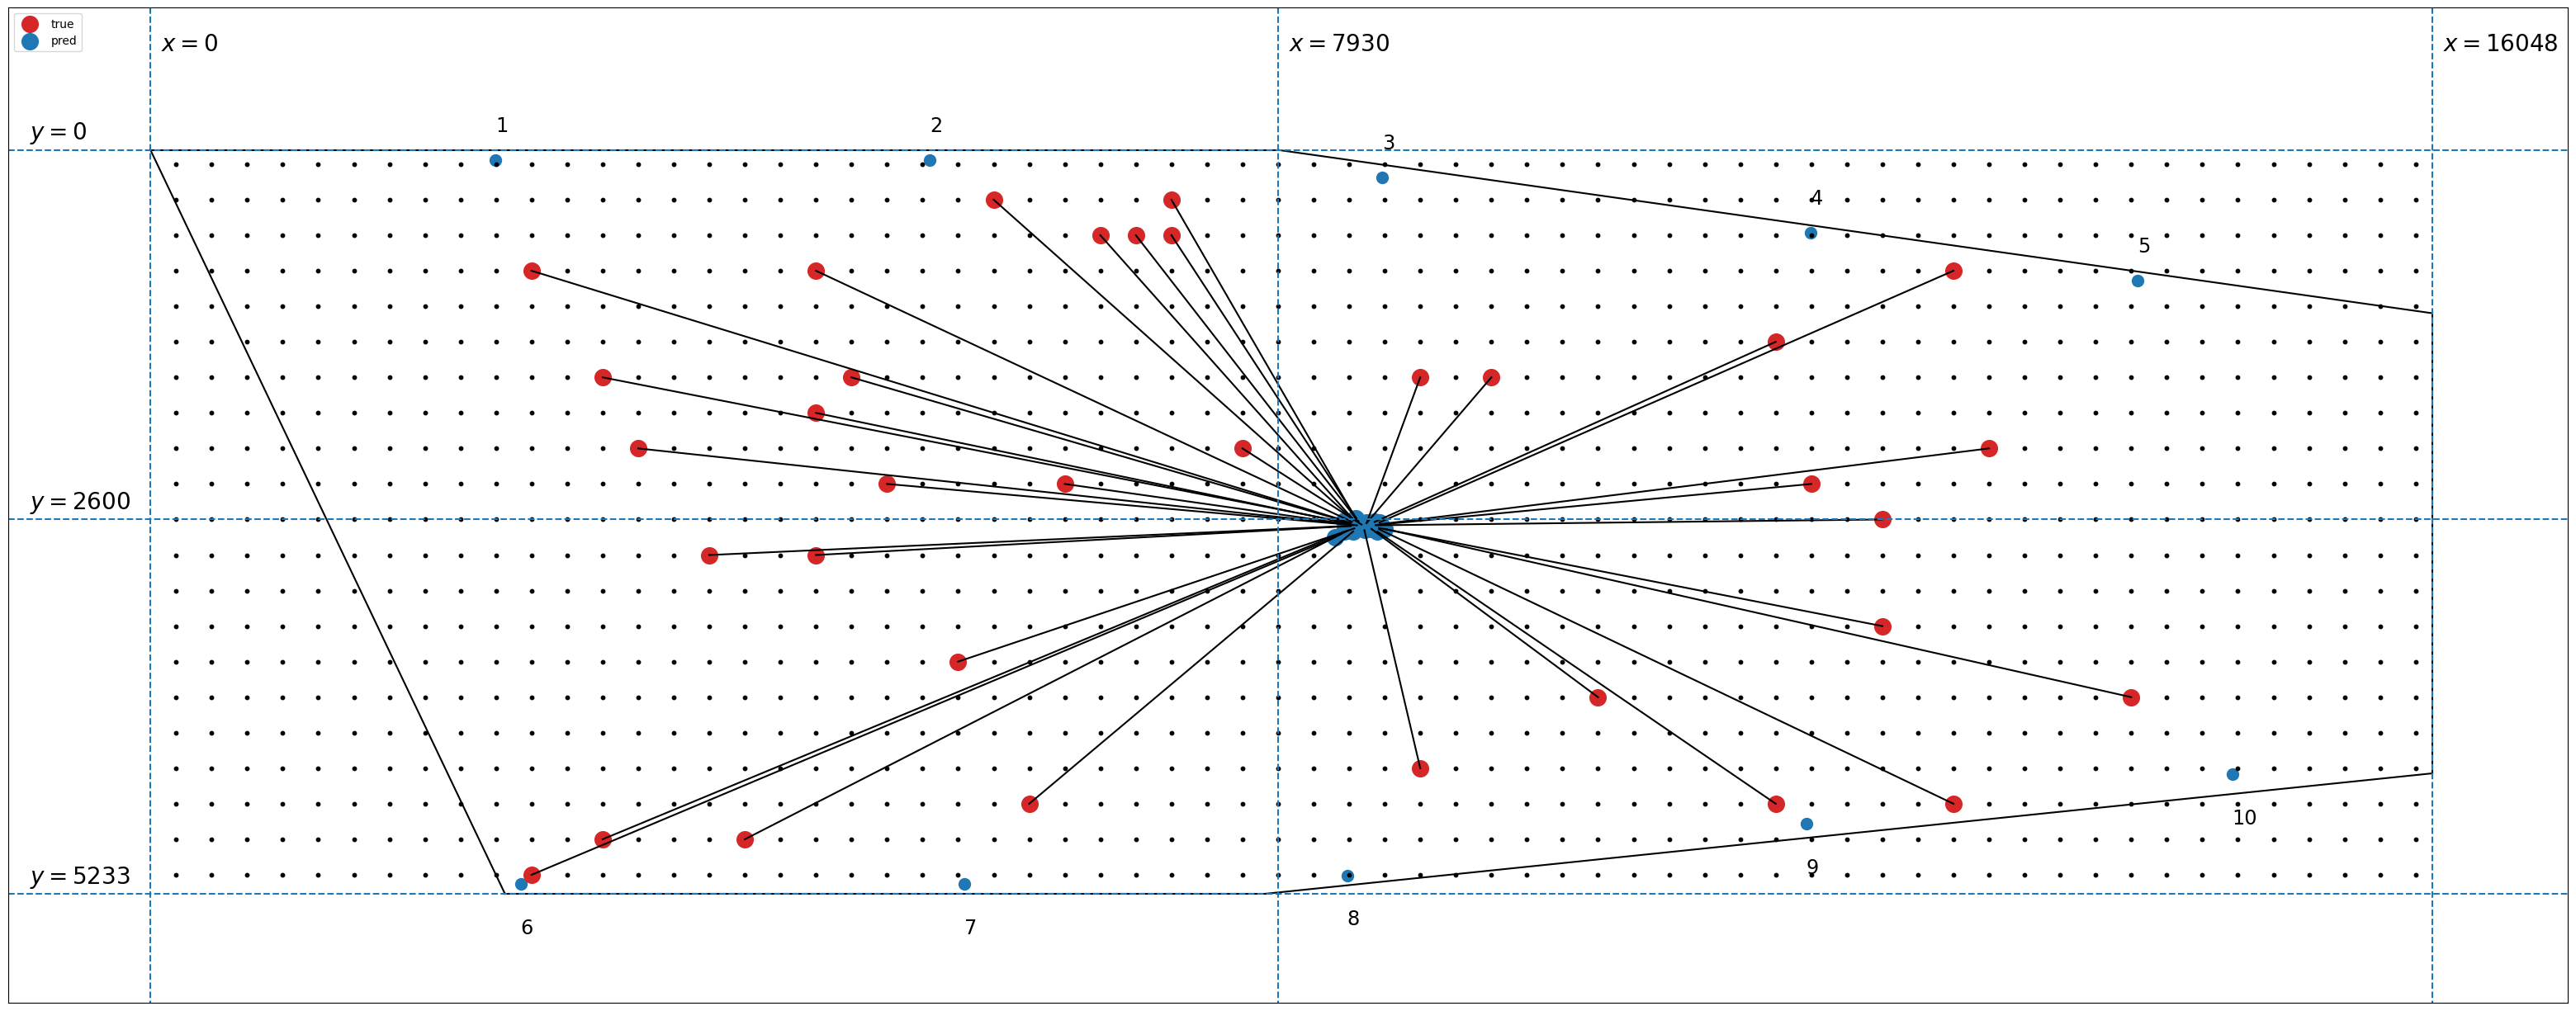

In [5]:
# plot of predicted and true value
plot_test_pred(y.to_numpy(), leakage.to_numpy())